In [ ]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy
import sklearn.linear_model as lm

In [ ]:
df = pd.read_csv('/content/green_tripdata_2020-01.csv')
df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,2019-12-18 15:52:30,2019-12-18 15:54:39,N,1.0,264,264,5.0,0.00,3.50,0.50,0.5,0.01,0.0,NaN,0.3,4.81,1.0,1.0,0.00
1,2.0,2020-01-01 00:45:58,2020-01-01 00:56:39,N,5.0,66,65,2.0,1.28,20.00,0.00,0.0,4.06,0.0,NaN,0.3,24.36,1.0,2.0,0.00
2,2.0,2020-01-01 00:41:38,2020-01-01 00:52:49,N,1.0,181,228,1.0,2.47,10.50,0.50,0.5,3.54,0.0,NaN,0.3,15.34,1.0,1.0,0.00
3,1.0,2020-01-01 00:52:46,2020-01-01 01:14:21,N,1.0,129,263,2.0,6.30,21.00,3.25,0.5,0.00,0.0,NaN,0.3,25.05,2.0,1.0,2.75
4,1.0,2020-01-01 00:19:57,2020-01-01 00:30:56,N,1.0,210,150,1.0,2.30,10.00,0.50,0.5,0.00,0.0,NaN,0.3,11.30,1.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447765,NaN,2020-01-31 23:29:00,2020-01-31 23:47:00,NaN,NaN,167,32,NaN,4.58,23.21,2.75,0.0,0.00,0.0,NaN,0.3,26.26,NaN,NaN,NaN
447766,NaN,2020-01-31 23:57:00,2020-02-01 00:23:00,NaN,NaN,81,69,NaN,6.55,27.27,2.75,0.0,0.00,0.0,NaN,0.3,30.32,NaN,NaN,NaN
447767,NaN,2020-01-31 23:57:00,2020-02-01 00:10:00,NaN,NaN,244,241,NaN,3.34,25.95,2.75,0.0,0.00,0.0,NaN,0.3,29.00,NaN,NaN,NaN
447768,NaN,2020-01-31 23:27:00,2020-02-01 00:04:00,NaN,NaN,68,17,NaN,8.92,30.39,2.75,0.0,0.00,0.0,NaN,0.3,33.44,NaN,NaN,NaN


In [ ]:
df.describe() # рассмотрим общую картину данных

,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,331719.000000,331719.000000,447770.000000,447770.000000,331719.000000,447770.000000,447770.000000,447770.000000,447770.000000,447770.000000,447770.000000,0.0,447770.000000,447770.000000,331719.000000,331718.000000,331719.000000
mean,1.830317,1.101661,108.121236,128.864473,1.304110,3.599392,15.839504,0.838858,0.388785,0.899788,0.327172,NaN,0.287046,18.898600,1.452841,1.023032,0.472377
std,0.375354,0.664471,71.165956,76.446125,0.953394,4.257709,12.691982,1.149168,0.210808,2.319882,1.458425,NaN,0.064305,14.101771,0.518710,0.150004,1.037282
min,1.000000,1.000000,1.000000,1.000000,0.000000,-33.690000,-210.000000,-4.500000,-0.500000,-2.800000,-6.120000,NaN,-0.300000,-210.300000,1.000000,1.000000,-2.750000
25%,2.000000,1.000000,52.000000,63.000000,1.000000,1.080000,7.000000,0.000000,0.500000,0.000000,0.000000,NaN,0.300000,9.120000,1.000000,1.000000,0.000000
50%,2.000000,1.000000,82.000000,129.000000,1.000000,2.070000,11.500000,0.500000,0.500000,0.000000,0.000000,NaN,0.300000,14.400000,1.000000,1.000000,0.000000
75%,2.000000,1.000000,166.000000,194.000000,1.000000,4.410000,21.000000,1.000000,0.500000,1.460000,0.000000,NaN,0.300000,24.550000,2.000000,1.000000,0.000000
max,2.000000,99.000000,265.000000,265.000000,9.000000,130.680000,753.000000,8.250000,3.550000,450.000000,96.120000,NaN,0.300000,753.800000,5.000000,2.000000,2.750000


In [ ]:
df.isnull().sum() # данные достаточно чистые, если рассматривать только интересующие столбцы

VendorID                 116051
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag       116051
RatecodeID               116051
PULocationID                  0
DOLocationID                  0
passenger_count          116051
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                447770
improvement_surcharge         0
total_amount                  0
payment_type             116051
trip_type                116052
congestion_surcharge     116051
dtype: int64

## Поиск аномальных поездок

In [ ]:
df['total_amount'].min() # часть поездок имеет орицательную итоговую стоимость

-210.3

In [ ]:
df['total_amount'].max() # а также  есть существенные выбросы в большую сторону - стоимость поездки на такси врядли будет составлять 753.8 $

753.8

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


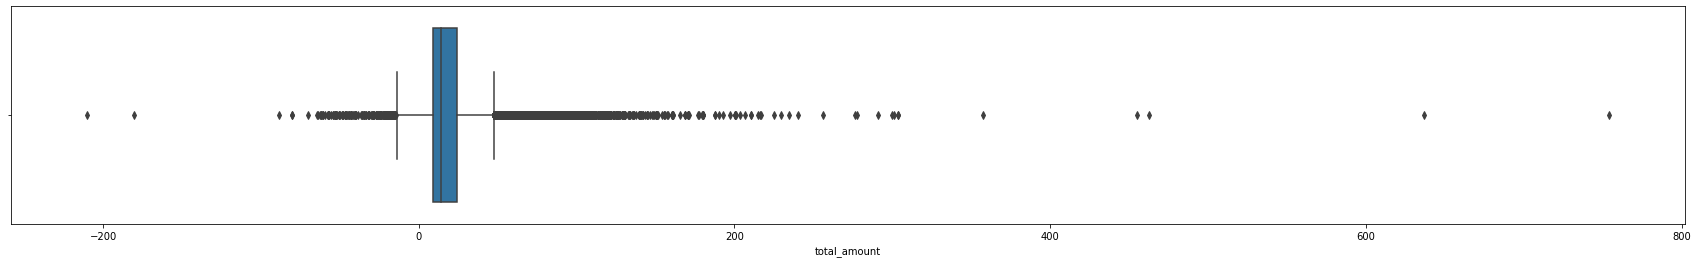

In [ ]:
plt.figure(figsize=(30,4)) # на графике по итоговой цене показаны аномалии по выборосам
sns.boxplot(df['total_amount'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


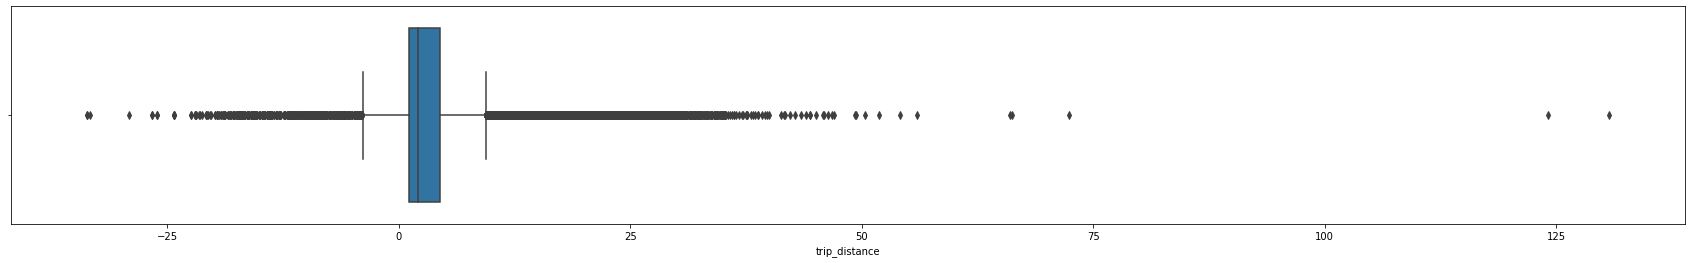

In [ ]:
plt.figure(figsize=(30,4)) # также на графике по дистанции поездки отрицательные значения и несколько выборосов
sns.boxplot(df['trip_distance'])

## Проверка гипотезы о нормальном распределение по стоимости
нулевая гипотеза - нормальное распределение

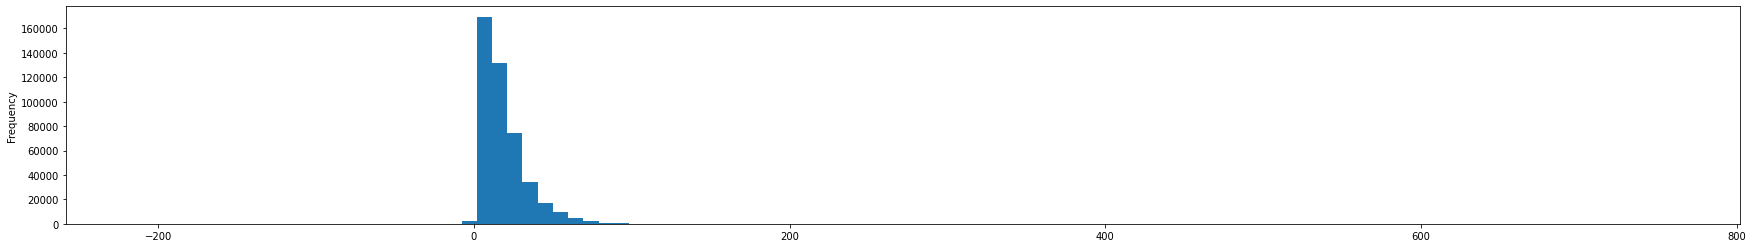

In [ ]:
plt.figure(figsize=(30,4))
df['total_amount'].plot.hist(bins = 100, label = 'total_amount')

График распределения: унимодальный, положительный. График похож на логонормальное распределение. Проверяем гипотезу.

In [ ]:
stat, p = scipy.stats.shapiro(df['total_amount'])
p

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.0

гипотеза подтвердилась. мы имеем дело с нормальным распределением.

## Корреляция

In [ ]:
table = df.iloc[:,[7,8,9,10,11,12,13,15,16,17,18]] # оставляем числовые переменные, которые могут влиять на стоимость
table.corr()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type
passenger_count,1.000000,0.009466,-0.006714,-0.008160,0.003000,0.006240,-0.004514,0.002634,-0.003582,0.015269,-0.007092
trip_distance,0.009466,1.000000,0.835261,0.276670,-0.328465,0.056151,0.514307,-0.069587,0.834405,-0.085678,0.025506
fare_amount,-0.006714,0.835261,1.000000,0.388232,-0.407927,0.032393,0.439225,-0.078871,0.977012,-0.150939,0.103174
extra,-0.008160,0.276670,0.388232,1.000000,-0.449854,-0.110472,0.133736,-0.137127,0.408653,-0.057854,-0.101546
mta_tax,0.003000,-0.328465,-0.407927,-0.449854,1.000000,0.178325,-0.172391,0.066602,-0.365742,-0.138386,-0.738870
tip_amount,0.006240,0.056151,0.032393,-0.110472,0.178325,1.000000,0.015350,0.069465,0.206219,-0.403834,0.003037
tolls_amount,-0.004514,0.514307,0.439225,0.133736,-0.172391,0.015350,1.000000,-0.036513,0.506958,-0.062911,0.011420
improvement_surcharge,0.002634,-0.069587,-0.078871,-0.137127,0.066602,0.069465,-0.036513,1.000000,-0.064559,-0.187682,-0.324645
total_amount,-0.003582,0.834405,0.977012,0.408653,-0.365742,0.206219,0.506958,-0.064559,1.000000,-0.246033,0.074147
payment_type,0.015269,-0.085678,-0.150939,-0.057854,-0.138386,-0.403834,-0.062911,-0.187682,-0.246033,1.000000,0.034650


total_amount имеет наибольшую корреляция со столбцами: trip_distance (расстояние поездки) и fare_amount (тип тарифа) 

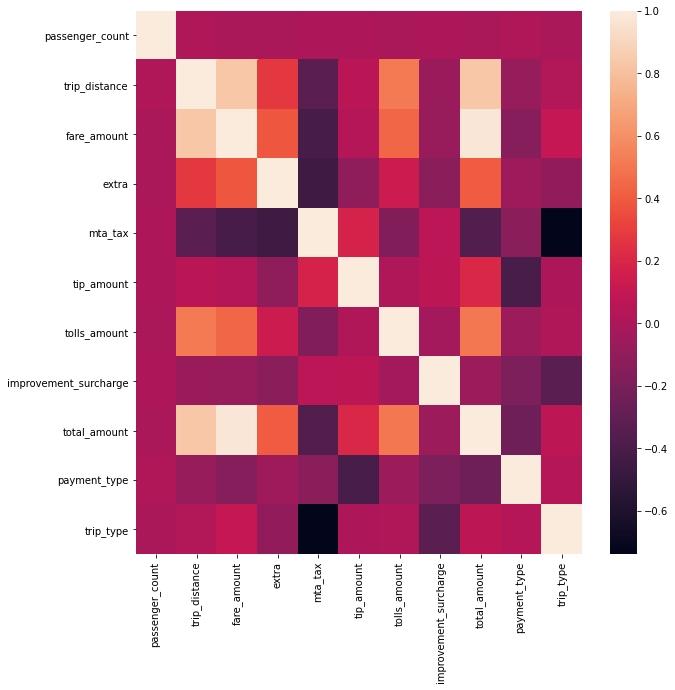

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(table.corr())

## Модель

In [ ]:
table

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type
0,5.0,0.00,3.50,0.50,0.5,0.01,0.0,0.3,4.81,1.0,1.0
1,2.0,1.28,20.00,0.00,0.0,4.06,0.0,0.3,24.36,1.0,2.0
2,1.0,2.47,10.50,0.50,0.5,3.54,0.0,0.3,15.34,1.0,1.0
3,2.0,6.30,21.00,3.25,0.5,0.00,0.0,0.3,25.05,2.0,1.0
4,1.0,2.30,10.00,0.50,0.5,0.00,0.0,0.3,11.30,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
447765,NaN,4.58,23.21,2.75,0.0,0.00,0.0,0.3,26.26,NaN,NaN
447766,NaN,6.55,27.27,2.75,0.0,0.00,0.0,0.3,30.32,NaN,NaN
447767,NaN,3.34,25.95,2.75,0.0,0.00,0.0,0.3,29.00,NaN,NaN
447768,NaN,8.92,30.39,2.75,0.0,0.00,0.0,0.3,33.44,NaN,NaN


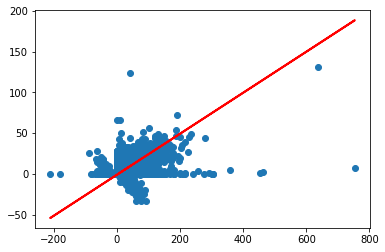

In [ ]:
# sns.pairplot(df)
X = table[['total_amount']].values
y = table[['trip_distance']].values
slr = lm.LinearRegression()
slr.fit(X, y)
plt.scatter(X, y)
plt.plot(X, slr.predict(X), color='red', linewidth=2)

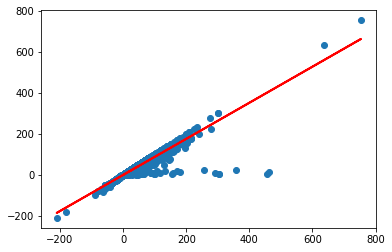

In [ ]:
X = table[['total_amount']].values
y = table[['fare_amount']].values
slr = lm.LinearRegression()
slr.fit(X, y)
plt.scatter(X, y)
plt.plot(X, slr.predict(X), color='red', linewidth=2)

Между расстоянием поездки и ценой прямая зависимость. Но по графику линейной регресси мы видим, что и между ценой поездки и тарифом также есть отклонения - вероятно они и указывают на скидки и акции.